<a href="https://colab.research.google.com/github/kalinkabel/Vis-o_Computacional/blob/main/Segmenta%C3%A7%C3%A3o_Sem%C3%A2ntica_Microsc%C3%B3picas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importação das bibliotecas

In [1]:
import os
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from tqdm import tqdm
from matplotlib import pyplot as plt
import tensorflow
import random
tensorflow.__version__

'2.12.0'

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Dataset

- **Data Science Bowl de 2018** - https://www.kaggle.com/c/data-science-bowl-2018

In [3]:
os.environ['KAGGLE_USERNAME'] = 'gabevr'
os.environ['KAGGLE_KEY'] = 'ca479e66ac6ae221b62be68f056aca65'

In [4]:
!kaggle competitions download -c data-science-bowl-2018

 98% 351M/358M [00:03<00:00, 107MB/s] 
100% 358M/358M [00:03<00:00, 111MB/s]


In [5]:
!unzip data-science-bowl-2018.zip

Archive:  data-science-bowl-2018.zip
  inflating: stage1_sample_submission.csv.zip  
  inflating: stage1_solution.csv.zip  
  inflating: stage1_test.zip         
  inflating: stage1_train.zip        
  inflating: stage1_train_labels.csv.zip  
  inflating: stage2_sample_submission_final.csv.zip  
  inflating: stage2_test_final.zip   


In [6]:
!unzip stage1_train.zip -d /content/treinamento/
!unzip stage1_test.zip -d /content/teste/

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: /content/treinamento/d52958107d0b1f0288f50f346a833df3df485b92d5516cfcb536e73ab7adafd0/masks/d86ee01921b1c9ed23c342952253682060512483c39c8b7b5c6d8350f6df2568.png  
  inflating: /content/treinamento/d52958107d0b1f0288f50f346a833df3df485b92d5516cfcb536e73ab7adafd0/masks/d8b76279ad8f2e101bb8c5ca95229b6532903eea035ef945dd4a21356d49dead.png  
  inflating: /content/treinamento/d52958107d0b1f0288f50f346a833df3df485b92d5516cfcb536e73ab7adafd0/masks/dc05f946c096c5fcc147024843f21c06c3a94af25d4f37b498ea937953b806fe.png  
  inflating: /content/treinamento/d52958107d0b1f0288f50f346a833df3df485b92d5516cfcb536e73ab7adafd0/masks/e0fd1c4e98bb470bea315e7d8f74396450fe93e93f68e1f8a3443b2b397c8640.png  
  inflating: /content/treinamento/d52958107d0b1f0288f50f346a833df3df485b92d5516cfcb536e73ab7adafd0/masks/e4b6643cafde8ac789b63f7b1a023773960dbe63489963985033619fde052dc9.png  
  inflating: /content/treinamento/d52958107d0b1f0288f50f346a8

# Carregamento das imagens

In [7]:
img_largura = 256
img_altura = 256
img_canais = 3

In [8]:
seed = 42
np.random.seed = seed
random.seed = seed
path_treinamento = 'treinamento/'
path_teste = 'teste/'

In [9]:
train_ids = next(os.walk(path_treinamento))[1]
test_ids = next(os.walk(path_teste))[1]

In [10]:
len(train_ids), len(test_ids)

(670, 65)

In [11]:
dataset_img = np.zeros((len(train_ids), img_altura, img_largura, img_canais), dtype=np.uint8)
dataset_mask = np.zeros((len(train_ids), img_altura, img_largura, 1), dtype=np.bool)

<ipython-input-11-54c09157d135>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dataset_mask = np.zeros((len(train_ids), img_altura, img_largura, 1), dtype=np.bool)


In [12]:
dataset_img.shape, dataset_mask.shape

((670, 256, 256, 3), (670, 256, 256, 1))

# Pré-processamento das imagens

In [13]:
print('Redimensionando imagens e máscaras de treinamento')
for n, id_, in tqdm(enumerate(train_ids), total=len(train_ids)):
  path = path_treinamento + id_
  #print(path)
  if "." in path: # .ipynb_checkpoints
    continue

  img = cv2.imread(path + '/images/' + id_ + '.png')[:,:,:img_canais]
  img = cv2.resize(img, (img_altura, img_largura))
  dataset_img[n] = img
  mask = np.zeros((img_altura, img_largura, 1), dtype=np.bool)

  for mask_file in next(os.walk(path + '/masks/'))[2]:
    mask_ = cv2.imread(path + '/masks/' + mask_file)
    mask_ = cv2.cvtColor(mask_, cv2.COLOR_BGR2GRAY)
    mask_ = np.expand_dims(cv2.resize(mask_, (img_altura, img_largura)), axis = -1)
    mask = np.maximum(mask, mask_)

  dataset_mask[n] = mask

Redimensionando imagens e máscaras de treinamento


  0%|          | 0/670 [00:00<?, ?it/s]<ipython-input-13-89fdda6661e5>:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((img_altura, img_largura, 1), dtype=np.bool)
100%|██████████| 670/670 [00:42<00:00, 15.87it/s]


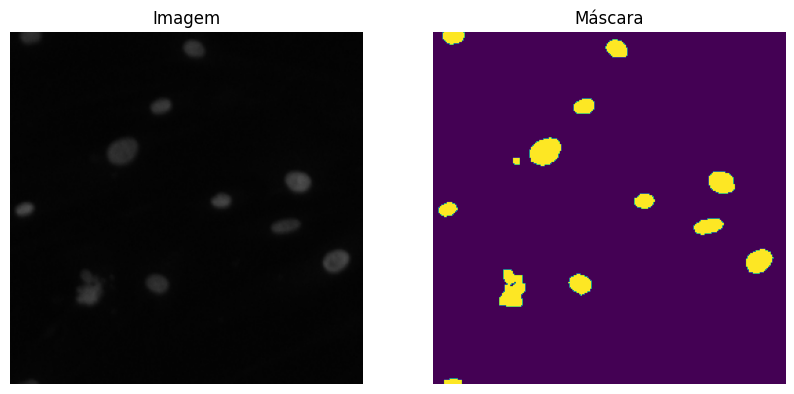

In [14]:
id_img = 6
fig = plt.figure(figsize=(10,7))

fig.add_subplot(1,2,1)
plt.imshow(dataset_img[id_img])
plt.axis('off')
plt.title('Imagem')

fig.add_subplot(1,2,2)
plt.imshow(np.squeeze(dataset_mask[id_img]))
plt.axis('off')
plt.title('Máscara');

In [15]:
X_test = np.zeros((len(test_ids), img_altura, img_largura, img_canais), dtype=np.uint8)
redim_test = []
print('Redimensionando imagens de teste')
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    if "." in path:
        continue

    path = path_teste + id_
    img = cv2.imread(path + '/images/' + id_ + '.png')[:,:,:img_canais]
    redim_test.append([img.shape[0], img.shape[1]])
    img = cv2.resize(img, (img_altura, img_largura))
    X_test[n] = img

print('Ok!')
print(X_test.shape)

Redimensionando imagens de teste


100%|██████████| 65/65 [00:00<00:00, 132.35it/s]

Ok!
(65, 256, 256, 3)


In [16]:
# Treinamento, Validação, Teste
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(dataset_img, dataset_mask, test_size = 0.10, random_state = 42)

In [17]:
X_train.shape

(603, 256, 256, 3)

In [18]:
X_val.shape

(67, 256, 256, 3)

In [19]:
y_train.shape

(603, 256, 256, 1)

In [20]:
y_val.shape

(67, 256, 256, 1)

# Construção da rede neural

In [21]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda, ReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, MaxPool2D, Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

## Convolução

In [22]:
# Padding: https://www.pico.net/kb/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-tensorflow/
def bloco_conv(input, num_filters):
  x = Conv2D(num_filters, 3, padding='same')(input)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(num_filters, 3, padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  return x

## Encoder

In [23]:
def bloco_encoder(input, num_filters):
  x = bloco_conv(input, num_filters)
  p = MaxPool2D((2,2))(x)
  return x, p

## Decoder

In [24]:
def bloco_decoder(input, skip_features, num_filters):
  x = Conv2DTranspose(num_filters, (2,2), strides=2, padding='same')(input)
  x = Concatenate()([x, skip_features])
  x = bloco_conv(x, num_filters)
  return x

## Modelo final

In [25]:
def modelo_unet(input_shape):
  inputs = Input(input_shape)

  s1, p1 = bloco_encoder(inputs, 64)
  s2, p2 = bloco_encoder(p1, 128)
  s3, p3 = bloco_encoder(p2, 256)
  s4, p4 = bloco_encoder(p3, 512)

  b1 = bloco_conv(p4, 1024)

  d1 = bloco_decoder(b1, s4, 512)
  d2 = bloco_decoder(d1, s3, 256)
  d3 = bloco_decoder(d2, s2, 128)
  d4 = bloco_decoder(d3, s1, 64)

  outputs = Conv2D(1, 1, padding='same', activation='sigmoid')(d4)

  model = Model(inputs, outputs, name='UNet')
  return model

In [26]:
model = modelo_unet((img_altura, img_largura, img_canais))
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                              

In [27]:
arquivo_modelo = 'modelo_unet.json'
modelo_json = model.to_json()
with open(arquivo_modelo, 'w') as json_file:
  json_file.write(modelo_json)

## Callbacks

In [28]:
nome_modelo = 'modelo_unet.h5'
checkpointer = ModelCheckpoint(nome_modelo, verbose=1, save_best_only=True)
early_stopper = EarlyStopping(patience = 5, monitor='val_loss')
callbacks = [checkpointer, early_stopper]

# Treinamento

In [29]:
epochs = 15
batch_size = 8

In [30]:
history = model.fit(X_train, y_train, batch_size = batch_size, epochs=epochs, validation_data=(X_val, y_val), callbacks=[callbacks])

Epoch 1/15
76/76 [==============================] - ETA: 0s - loss: 0.3814 - accuracy: 0.8788
Epoch 1: val_loss improved from inf to 0.45748, saving model to modelo_unet.h5
76/76 [==============================] - 84s 630ms/step - loss: 0.3814 - accuracy: 0.8788 - val_loss: 0.4575 - val_accuracy: 0.9523
Epoch 2/15
76/76 [==============================] - ETA: 0s - loss: 0.1687 - accuracy: 0.9637
Epoch 2: val_loss improved from 0.45748 to 0.25420, saving model to modelo_unet.h5
76/76 [==============================] - 45s 588ms/step - loss: 0.1687 - accuracy: 0.9637 - val_loss: 0.2542 - val_accuracy: 0.9522
Epoch 3/15
76/76 [==============================] - ETA: 0s - loss: 0.1464 - accuracy: 0.9642
Epoch 3: val_loss improved from 0.25420 to 0.20895, saving model to modelo_unet.h5
76/76 [==============================] - 45s 597ms/step - loss: 0.1464 - accuracy: 0.9642 - val_loss: 0.2090 - val_accuracy: 0.9569
Epoch 4/15
76/76 [==============================] - ETA: 0s - loss: 0.1238 - 

In [31]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [32]:
def mostrar_graficos(history):
  fig = plt.gcf()
  fig.set_size_inches(16,4)
  plt.subplot(1,2,1)
  plt.plot(history.history['accuracy'], 'red', label='Accuracy treinamento')
  plt.plot(history.history['val_accuracy'], 'blue', label='Accuracy validação')
  plt.legend()
  plt.title('Accuracy')

  plt.subplot(1,2,2)
  plt.plot(history.history['loss'], 'red', label='Loss treinamento')
  plt.plot(history.history['val_loss'], 'blue', label='Loss validação')
  plt.legend()
  plt.title('Loss')
  plt.show()

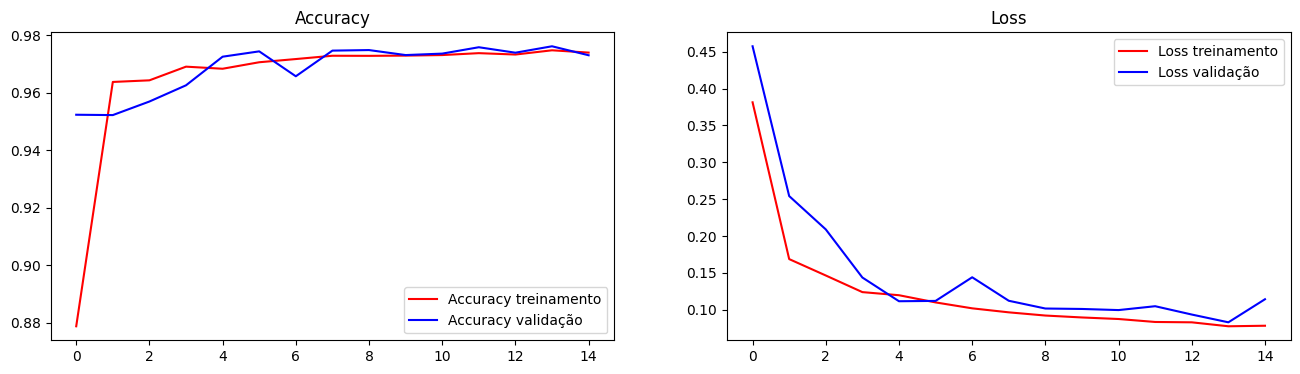

In [33]:
mostrar_graficos(history)

# Testes

## Imagens de validação

In [34]:
len(X_val)

67

In [35]:
predicoes_val = model.predict(X_val)

3/3 [==============================] - 19s 268ms/step


In [36]:
predicoes_val.shape # sigmoide

(67, 256, 256, 1)

In [37]:
predicoes_val[0].min(), predicoes_val[0].max()

(0.005620817, 1.0)

In [38]:
predicoes_val = (predicoes_val > 0.5).astype(np.uint8)
predicoes_val

array([[[[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        ...,

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]]],


       [[[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        ...,

        [[0],
         [0],
         [0],
         ...,
         [0],


In [39]:
np.unique(predicoes_val[0], return_counts=True)

(array([0, 1], dtype=uint8), array([64285,  1251]))

In [40]:
def compara_segmentacoes(original, ground_truth, predicao):
  fig = plt.figure(figsize=(12, 7))

  fig.add_subplot(1,3,1)
  plt.imshow(original)
  plt.axis("off")
  plt.title("Imagem Original")

  fig.add_subplot(1,3,2)
  plt.imshow(ground_truth)
  plt.axis("off")
  plt.title("Máscara real (ground truth)")

  fig.add_subplot(1,3,3)
  plt.imshow(predicao)
  plt.axis("off")
  plt.title("Predição")

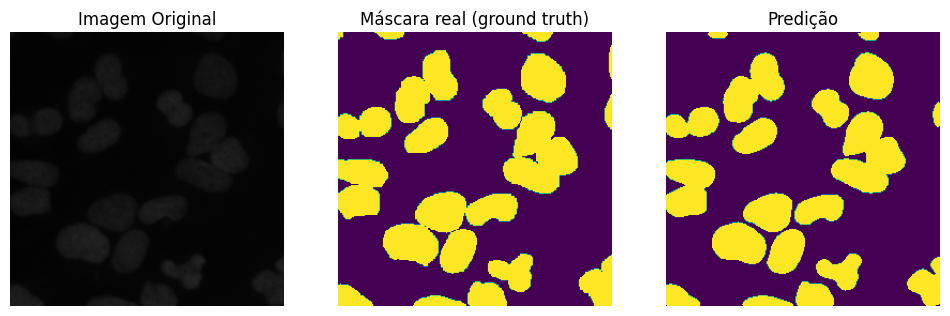

In [41]:
idx = 30
compara_segmentacoes(X_val[idx], np.squeeze(y_val[idx]), np.squeeze(predicoes_val[idx]))

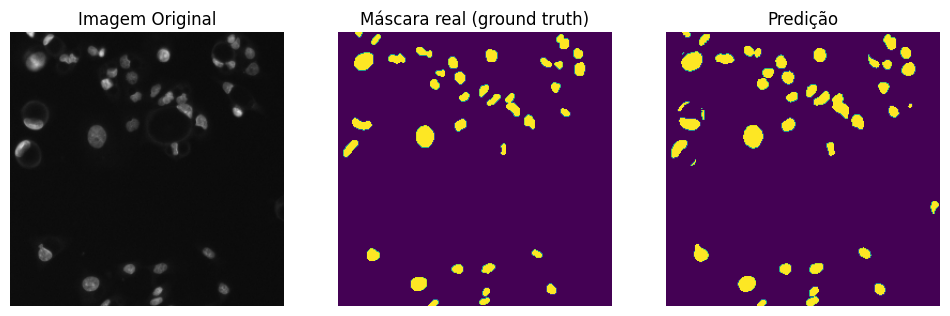

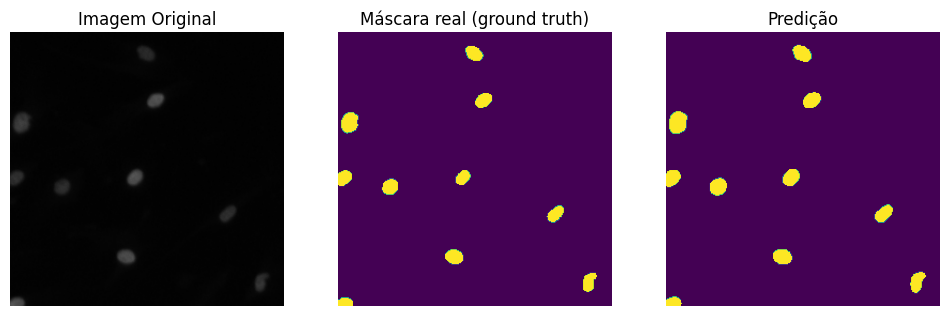

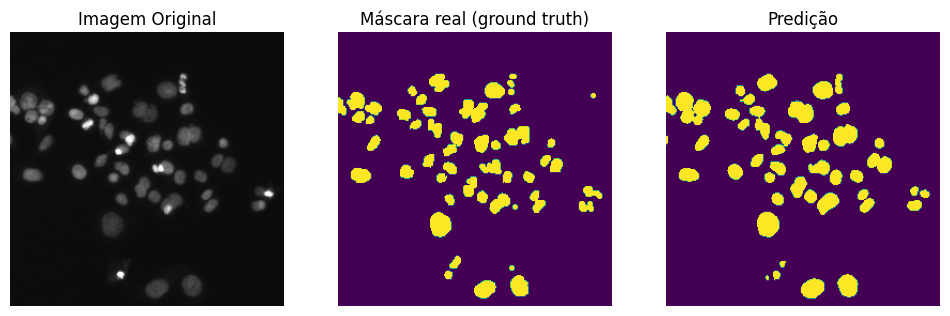

In [42]:
imgs_teste = np.random.choice(len(X_val), 3)
for img_id in imgs_teste:
  compara_segmentacoes(X_val[img_id], np.squeeze(y_val[img_id]), np.squeeze(predicoes_val[img_id]))

## Imagens de teste

In [43]:
predicoes_teste = model.predict(X_test)
predicoes_teste = (predicoes_teste > 0.5).astype(np.uint8)

3/3 [==============================] - 3s 1s/step


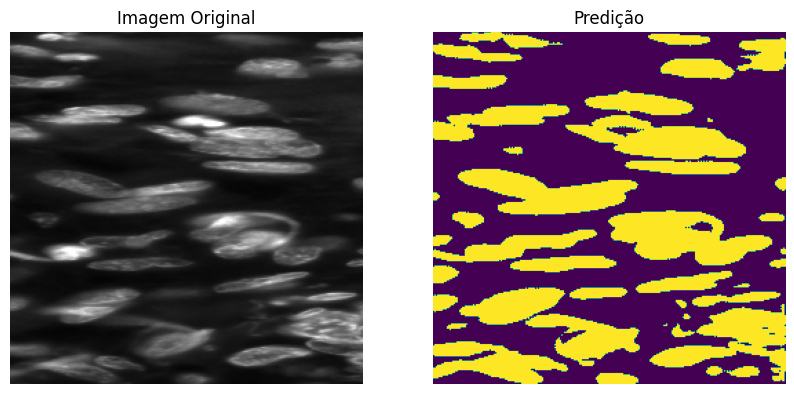

In [44]:
idx = random.randint(0, len(X_test))

fig = plt.figure(figsize=(10, 7))

fig.add_subplot(1,2,1)
plt.imshow(X_test[idx])
plt.axis("off")
plt.title("Imagem Original")

fig.add_subplot(1,2,2)
plt.imshow(np.squeeze(predicoes_teste[idx]))
plt.axis("off")
plt.title("Predição");

# Avaliação

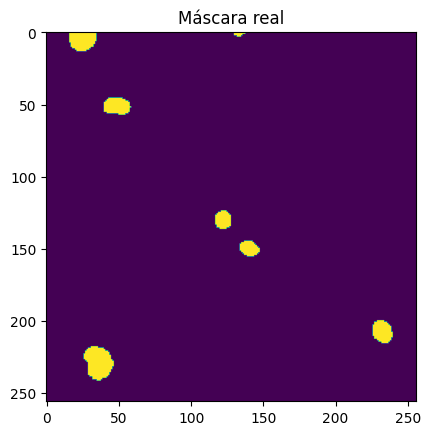

In [45]:
id_img_teste = 0
img_teste = X_val[id_img_teste]
ground_truth = y_val[id_img_teste]
plt.imshow(np.squeeze(ground_truth))
plt.title('Máscara real');

In [46]:
from tensorflow.keras.metrics import MeanIoU
iou_resultado = MeanIoU(num_classes = 2)

In [47]:
img_teste.shape

(256, 256, 3)

In [48]:
test_img_input = np.expand_dims(img_teste, 0)
test_img_input.shape

(1, 256, 256, 3)

In [49]:
predicao = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

1/1 [==============================] - 0s 22ms/step


In [50]:
predicao

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [51]:
ground_truth.shape, ground_truth[:,:,0].shape

((256, 256, 1), (256, 256))

IoU para a imagem:  0.8955636


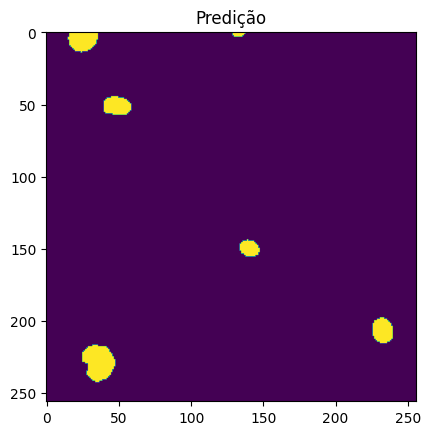

In [52]:
plt.imshow(predicao)
plt.title('Predição')
iou_resultado.update_state(ground_truth[:,:,0], predicao)
print('IoU para a imagem: ', iou_resultado.result().numpy())

In [53]:
import pandas as pd

valores_IoU = []
for idx in range(0, X_val.shape[0]):
    img = X_val[idx]
    ground_truth = y_val[idx]
    IoU = MeanIoU(num_classes=2)

    test_img_input=np.expand_dims(img, 0)
    predicao = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
    IoU.update_state(ground_truth[:,:,0], predicao)
    IoU_resultado = IoU.result().numpy()
    valores_IoU.append(IoU_resultado)
    print(IoU_resultado)

1/1 [==============================] - 0s 21ms/step
0.8955636
1/1 [==============================] - 0s 21ms/step
0.8663052
1/1 [==============================] - 0s 19ms/step
0.89090455
1/1 [==============================] - 0s 19ms/step
0.8962326
1/1 [==============================] - 0s 19ms/step
0.94079816
1/1 [==============================] - 0s 21ms/step
0.84569144
1/1 [==============================] - 0s 19ms/step
0.90115
1/1 [==============================] - 0s 20ms/step
0.9021082
1/1 [==============================] - 0s 21ms/step
0.9477288
1/1 [==============================] - 0s 26ms/step
0.90121007
1/1 [==============================] - 0s 27ms/step
0.954707
1/1 [==============================] - 0s 18ms/step
0.9183574
1/1 [==============================] - 0s 21ms/step
0.8865464
1/1 [==============================] - 0s 21ms/step
0.8680793
1/1 [==============================] - 0s 29ms/step
0.91562414
1/1 [==============================] - 0s 22ms/step
0.8269705
1/1 [=

In [54]:
df = pd.DataFrame(valores_IoU, columns=["IoU"])
df = df[df.IoU != 1.0]
df

,IoU
0,0.895564
1,0.866305
2,0.890905
3,0.896233
4,0.940798
...,...
62,0.781337
63,0.790600
64,0.940656
65,0.877637


In [55]:
media_IoU = df.mean().values
print("Média do IoU para "+str(len(valores_IoU))+" imagens: ", media_IoU)

Média do IoU para 67 imagens:  [0.89105177]


# Salvar e carregar a rede neural

In [56]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [57]:
nome_modelo

'modelo_unet.h5'

In [58]:
!cp /content/modelo_unet.h5 /content/gdrive/MyDrive/Cursos\ -\ recursos/Segmentação\ Imagens\ Python\ AZ/modelos/modelo_unet.h5
!cp /content/modelo_unet.json /content/gdrive/MyDrive/Cursos\ -\ recursos/Segmentação\ Imagens\ Python\ AZ/modelos/modelo_unet.json

cp: cannot create regular file '/content/gdrive/MyDrive/Cursos - recursos/Segmentação Imagens Python AZ/modelos/modelo_unet.h5': No such file or directory
cp: cannot create regular file '/content/gdrive/MyDrive/Cursos - recursos/Segmentação Imagens Python AZ/modelos/modelo_unet.json': No such file or directory


In [59]:
from tensorflow.keras.models import model_from_json

In [60]:
json_file = open('/content/modelo_unet.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
modelo2 = model_from_json(loaded_model_json)

In [61]:
modelo2.load_weights('/content/modelo_unet.h5')

In [62]:
modelo2.summary()

Model: "UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                              

1/1 [==============================] - 1s 556ms/step


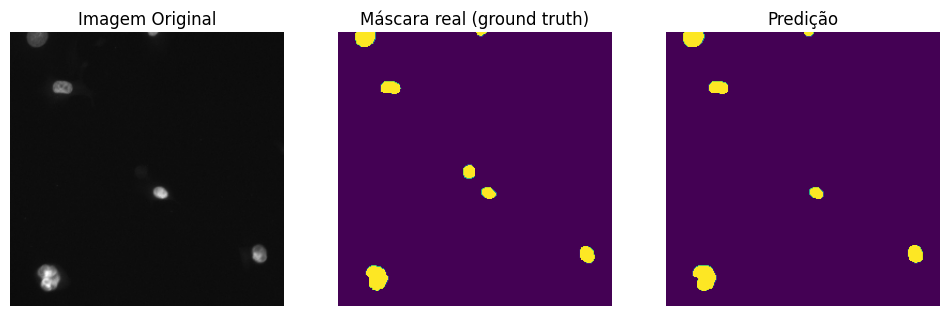

In [63]:
idx = 0

img_teste = np.expand_dims(X_val[idx], 0)
predicao_val = modelo2.predict(img_teste, verbose=1)
predicao_val = (predicao_val > 0.5).astype(np.uint8)

compara_segmentacoes(X_val[idx], np.squeeze(y_val[idx]), np.squeeze(predicao_val[idx]))